In [1]:
from functools import partial
import numpy as np
from matplotlib import pyplot as plt
import torch

import hydra
from omegaconf import DictConfig, OmegaConf

from renaissance.kinetics.jacobian_solver import check_jacobian

from helpers.ppo_agent import PPOAgent
from helpers.env import KineticEnv, KineticEnvStateless
from helpers.utils import reward_func, load_pkl

import logging
from hydra import initialize, compose
initialize(config_path="configs", version_base="1.1")


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-zm2v1mdk because the default path (/home/renaissance/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


hydra.initialize()

In [2]:
cfg = compose(config_name="train.yaml")

In [3]:
print("-" * 50)
print(OmegaConf.to_yaml(cfg))  # print config to verify
print("-" * 50)

# Call solvers from SKimPy
chk_jcbn = check_jacobian()
logging.disable(logging.CRITICAL)

# Integrate data
print("FYI: Loading kinetic and thermodynamic data.")
chk_jcbn._load_ktmodels(cfg.paths.met_model_name, 'fdp1') # Load kinetic and thermodynamic data
chk_jcbn._load_ssprofile(cfg.paths.met_model_name, 'fdp1', cfg.constraints.ss_idx) # Integrate steady state information

# Logger setup, todo: for now disabled, else we would get w&b run object
logger = None # get_logger(cfg)


--------------------------------------------------
method:
  parameter_dim: 384
  latent_dim: 99
  name: ppo_refinement
  actor_lr: 0.0003
  critic_lr: 0.001
  discount_factor: 0.99
  gae_lambda: 0.98
  clip_eps: 0.2
  value_loss_weight: 0.5
  entropy_loss_weight: 0.0
seed: 42
device: cpu
logger:
  project: rl-renaissance
  entity: ludekcizinsky
  tags:
  - dev
paths:
  names_km: data/varma_ecoli_shikki/parameter_names_km_fdp1.pkl
  output_dir: /home/renaissance/work/output
  met_model_name: varma_ecoli_shikki
constraints:
  min_km: -25
  max_km: 3
  ss_idx: 1712
reward:
  eig_partition: -2.5
  intermediate_steps_weight: 0.01
  n_samples: 10
env:
  p0_init_mean: 0
  p0_init_std: 1
  p_size: 384
training:
  num_episodes: 300
  max_steps_per_episode: 100
  batch_size: 25
  num_epochs: 10
  max_grad_norm: 0.5

--------------------------------------------------
FYI: Loading kinetic and thermodynamic data.


Process ForkPoolWorker-11:
Process ForkPoolWorker-31:
Process ForkPoolWorker-30:
Process ForkPoolWorker-32:
Process ForkPoolWorker-15:
Process ForkPoolWorker-22:
Process ForkPoolWorker-13:
Process ForkPoolWorker-16:
Process ForkPoolWorker-29:
Process ForkPoolWorker-17:
Process ForkPoolWorker-6:
Process ForkPoolWorker-27:
Process ForkPoolWorker-7:
Process ForkPoolWorker-26:
Process ForkPoolWorker-19:
Process ForkPoolWorker-21:
Process ForkPoolWorker-3:
Process ForkPoolWorker-10:
Process ForkPoolWorker-20:
Process ForkPoolWorker-18:
Process ForkPoolWorker-25:
Process ForkPoolWorker-8:
Process ForkPoolWorker-1:
Process ForkPoolWorker-5:
Process ForkPoolWorker-23:
Process ForkPoolWorker-14:
Process ForkPoolWorker-9:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-28:
Process ForkPoolWorker-12:
Process ForkPoolWorker-24:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Trace

In [4]:
# Initialize environment
names_km = load_pkl(cfg.paths.names_km)
reward_fn = partial(reward_func, chk_jcbn, names_km, cfg.reward.eig_partition)
env = KineticEnv(cfg, reward_fn)
env.seed(cfg.seed)

In [8]:
import os
run_id = 0
# go through cfg.paths.output_dir and count the number of runs
for i in range(1000):
    if os.path.exists(os.path.join(cfg.paths.output_dir, f"run_{i}")):
        run_id += 1
    else:
        break

In [9]:
import time
# Initialize PPO agent (actor and critic)
ppo_agent = PPOAgent(cfg, logger)

In [10]:
collect_rewards = []
collect_policy_loss = []
collect_value_loss = []
best_reward = float("-inf")
save_dir = os.path.join(cfg.paths.output_dir, f"run_{run_id}")
os.makedirs(save_dir, exist_ok=True)
# Training loop
episode_start_time = time.time()  # Track time for first episode

for episode in range(cfg.training.num_episodes):
    trajectory = ppo_agent.collect_trajectory(env)
    rewards = trajectory["rewards"]
    collect_rewards.append(rewards.numpy())
    min_rew, max_rew, mean_rew = rewards.min(), rewards.max(), rewards.mean()
    print(f"Episode {episode+1}/{cfg.training.num_episodes} - Min reward: {min_rew:.4f}, Max reward: {max_rew:.4f}, Mean reward: {mean_rew:.4f}, Last reward: {rewards[-1]:.4f}")

    policy_loss, value_loss, entropy = ppo_agent.update(trajectory)
    print(f"Episode {episode+1}/{cfg.training.num_episodes} - Policy loss: {policy_loss:.4f}, Value loss: {value_loss:.4f}, Entropy: {entropy:.4f}")

    episode_end_time = time.time()
    elapsed = episode_end_time - episode_start_time
    print(f"Time elapsed for episode {episode+1}: {elapsed:.2f} seconds")
    episode_start_time = episode_end_time
    
    collect_policy_loss.append(policy_loss)
    collect_value_loss.append(value_loss)

    # Save the best model based on the mean reward
    if rewards[-1] > best_reward:
        best_reward = rewards[-1]
        actor = ppo_agent.policy_net
        critic = ppo_agent.value_net
        torch.save(ppo_agent.policy_net.state_dict(), os.path.join(save_dir, f"actor_best.pth"))
        torch.save(ppo_agent.value_net.state_dict(), os.path.join(save_dir, f"critic_best.pth"))
        # Save the training data
        np.save(os.path.join(save_dir, "rewards.npy"), np.array(collect_rewards))
        np.save(os.path.join(save_dir, "policy_loss.npy"), np.array(collect_policy_loss))
        np.save(os.path.join(save_dir, "value_loss.npy"), np.array(collect_value_loss))
        # save the config file
        with open(os.path.join(save_dir, "config.yaml"), "w") as f:
            f.write(OmegaConf.to_yaml(cfg))

        print(f"Model saved at episode {episode + 1} with reward {rewards[-1]:.4f}")

# Save the training data
np.save(os.path.join(save_dir, "rewards.npy"), np.array(collect_rewards))
np.save(os.path.join(save_dir, "policy_loss.npy"), np.array(collect_policy_loss))
np.save(os.path.join(save_dir, "value_loss.npy"), np.array(collect_value_loss))
# save the config file
with open(os.path.join(save_dir, "config.yaml"), "w") as f:
    f.write(OmegaConf.to_yaml(cfg))


Episode 1/300 - Min reward: 0.0010, Max reward: 0.0815, Mean reward: 0.0368, Last reward: 0.0482
Episode 1/300 - Policy loss: 0.3055, Value loss: 6.3724, Entropy: 357.1958
Time elapsed for episode 1: 21.29 seconds
Model saved at episode 1 with reward 0.0482
Episode 2/300 - Min reward: 0.0010, Max reward: 0.1103, Mean reward: 0.0083, Last reward: 0.0010
Episode 2/300 - Policy loss: 0.2794, Value loss: 11.5481, Entropy: 361.7073
Time elapsed for episode 2: 21.33 seconds
Episode 3/300 - Min reward: 0.0010, Max reward: 0.0965, Mean reward: 0.0130, Last reward: 0.0010
Episode 3/300 - Policy loss: 0.1789, Value loss: 2.1679, Entropy: 366.0301
Time elapsed for episode 3: 21.20 seconds
Episode 4/300 - Min reward: 0.0010, Max reward: 0.0979, Mean reward: 0.0917, Last reward: 0.0978
Episode 4/300 - Policy loss: 0.2818, Value loss: 2.1470, Entropy: 369.9609
Time elapsed for episode 4: 21.15 seconds
Model saved at episode 4 with reward 0.0978
Episode 5/300 - Min reward: 0.0010, Max reward: 0.1586,

KeyboardInterrupt: 

In [11]:
collect_rewards = np.load(os.path.join(save_dir, "rewards.npy"))

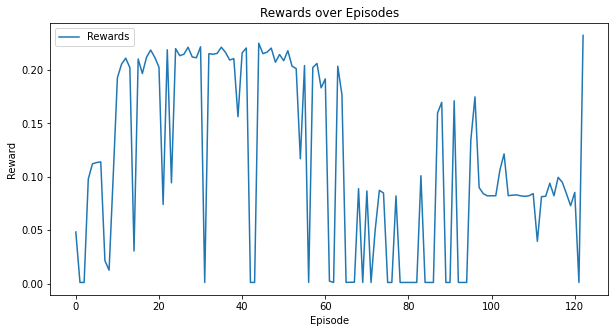

In [12]:
# plot the rewards
last_rewards = [rewards[-1] for rewards in collect_rewards]
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(collect_rewards)), last_rewards, label="Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Rewards over Episodes")
plt.legend()

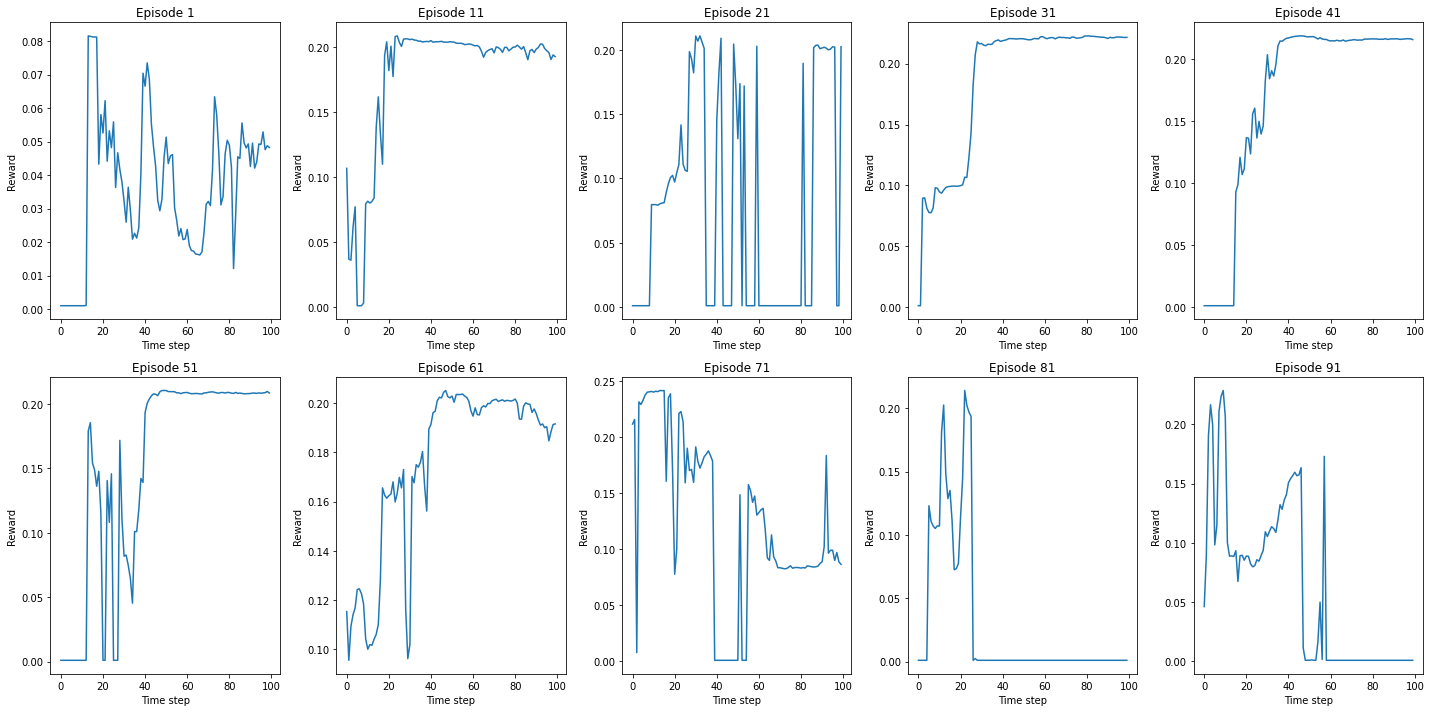

In [13]:
# plot 10 subplots in 2 x 5 grid, where each plot is one element of the collect_rewards
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    axs[i // 5, i % 5].plot(collect_rewards[10*i])
    axs[i // 5, i % 5].set_title(f"Episode {10*i + 1}")
    axs[i // 5, i % 5].set_xlabel("Time step")
    axs[i // 5, i % 5].set_ylabel("Reward")
plt.tight_layout()
plt.show()

In [ ]:
def evaluate_agent_incidence(cfg, actor_path, threshold, num_samples=100):
    # Load agent and policy weights
    agent = PPOAgent(cfg, logger)
    agent.policy_net.load_state_dict(torch.load(actor_path, map_location="cpu"))
    agent.policy_net.eval()

    count_above = 0
    for i in range(num_samples):
        trajectory = ppo_agent.collect_trajectory(env)
        reward = trajectory['rewards'][-1]
        if reward > threshold:
            count_above += 1
        print(f"Sample {i+1}/{num_samples}: Reward = {reward:.4f}")

    incidence_rate = count_above / num_samples
    print(f"Incidence rate (reward > {threshold}): {incidence_rate:.4f} ({count_above}/{num_samples})")
    return incidence_rate, rewards

In [ ]:
evaluate_agent_incidence(cfg, os.path.join(save_dir, f"actor_100.pth"), 0.5, num_samples=100)

FileNotFoundError: [Errno 2] No such file or directory: '/home/renaissance/work/output/run_4/actor_100.pth'